In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.optimize import curve_fit

import emcee
import corner

import uncertainties as un
import uncertainties.unumpy as unp
from uncertainties.unumpy import nominal_values, std_devs
err = std_devs
nom = nominal_values

from li_funks.plot import savefig

In [3]:
df = pd.read_pickle('data/processed_LiDataFull.pkl')  # use pickle to preserve uncertainty info
sdf = pd.read_pickle('data/processed_LiDataSummary.pkl')  # use pickle to preserve uncertainty info

lit = pd.read_pickle('data/processed_LiDataLiterature.pkl')
inorg = lit.loc['calcite']
fug = inorg.loc['Fuger2019']

In [103]:
# compile data

database = 'pitzer'

# Independent Variables
Rp = np.concatenate([nom(df.R.R_13C), nom(10**fug.solid.logR)])
Rp_err = err(df.R.R_13C)
Rp_err = np.concatenate([Rp_err, np.full(Rp.size - Rp_err.size, Rp_err.mean() * 2)])

mu = np.concatenate([df[database, 'mu'].values, fug[database, 'mu'].values])
temp = np.concatenate([df[database, 'temp(C)'].values, fug[database, 'temp(C)'].values])

la_OH = np.concatenate([df[database, 'la_OH-'].values, fug[database, 'la_OH-'].values])
OH = 10**la_OH
la_HCO3 = np.concatenate([df[database, 'la_HCO3-'].values, fug[database, 'la_HCO3-'].values])
HCO3 = 10**la_HCO3
la_Li = np.concatenate([df[database, 'la_Li+'].values, fug[database, 'la_Li+'].values])
m_Li = np.concatenate([df[database, 'm_Li+(mol/kgw)'].values, fug[database, 'm_Li+(mol/kgw)'].values])

Li_activity_ratio = 10**la_Li / m_Li

# Li Partitioning
DLi = np.concatenate([nom(df.OG.DLi), nom(fug.solid.DLi)])
DLi_err = np.concatenate([err(df.OG.DLi), fug.solid.DLi_2std / 2])

e7Li = np.concatenate([nom(df.Li_isotopes_vs_fluid.epsilon_og), nom(fug.solid.epsilon_7Li)])
e7Li_err = np.concatenate([err(df.Li_isotopes_vs_fluid.epsilon_og), fug.solid.epsilon_7Li_2std / 2])

e7Li_err = e7Li_err[~np.isnan(e7Li)]
e7Li = e7Li[~np.isnan(e7Li)]


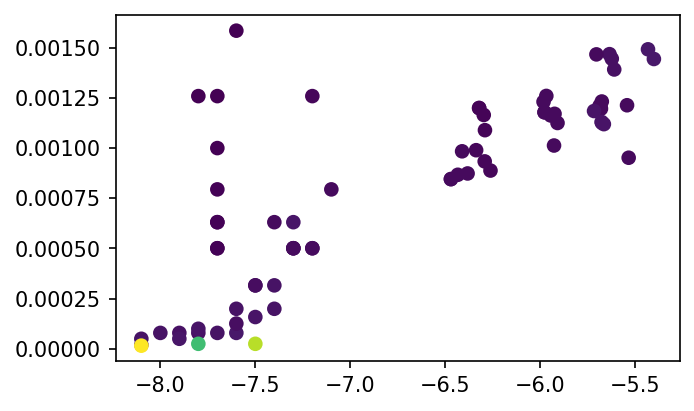

In [106]:
plt.scatter(np.log10(Rp), DLi, c=OH)

## Standard SKM

In [30]:
def SKM(Rp, Kf, Keq, Rb=6e-7):
    """
    DePaolo's (2011) Surface Kinetic Model
    
    Parameters
    ----------
    Kf : array-like
        The kinetic ('forward') fractionation factor.
        Kp will asymptote towards this value at high
        Rp.
    Keq : array-like
        The equilibrium fractionation factor. Kp will
        asymptote towards this values at low Rp.
    Rp : array-like
        Precipitation rate.
    Rb : array-like
        Ion detachment rate.

    Returns
    -------
    Kp : array-like
        Partitioning / fractionation of element in precipitated mineral.
    """
    return Kf / (1 + Rb * (Kf / Keq - 1) / (Rp + Rb))

def log_prior(theta):
    Kf, Keq, logRb = theta
    if np.any(Kf < 0) or np.any(Keq < 0):
        return -np.inf

    return np.sum(stats.truncnorm.logpdf(logRb, loc=-7, scale=1, a=-3, b=2))
    
def log_likelihood(theta, Rp, DLi, Rp_err, DLi_err):
    Kf, Keq, logRb = theta
    model = SKM(Rp, Kf, Keq, 10**logRb)
    sigma2 = DLi_err**2 + Rp_err**2
    return -0.5 * np.sum((DLi - model)**2 / sigma2 + np.log(sigma2))

def log_probability(theta, Rp, DLi, Rp_err, DLi_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Rp, DLi, Rp_err, DLi_err)

In [31]:
initial = 0.0014, 1e-5, -7

nwalkers = 32
ndim = len(initial)

start = initial + 1e-7 * np.random.randn(nwalkers, len(initial))

ind = np.isclose(la_OH, -6, atol=0.5)
# ind = np.ones(Rp.shape, dtype=bool)
inputs = (Rp[ind], DLi[ind], Rp_err[ind], DLi_err[ind])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=inputs)
sampler.run_mcmc(start, 5000, progress=True);


100%|██████████| 5000/5000 [00:21<00:00, 235.08it/s]


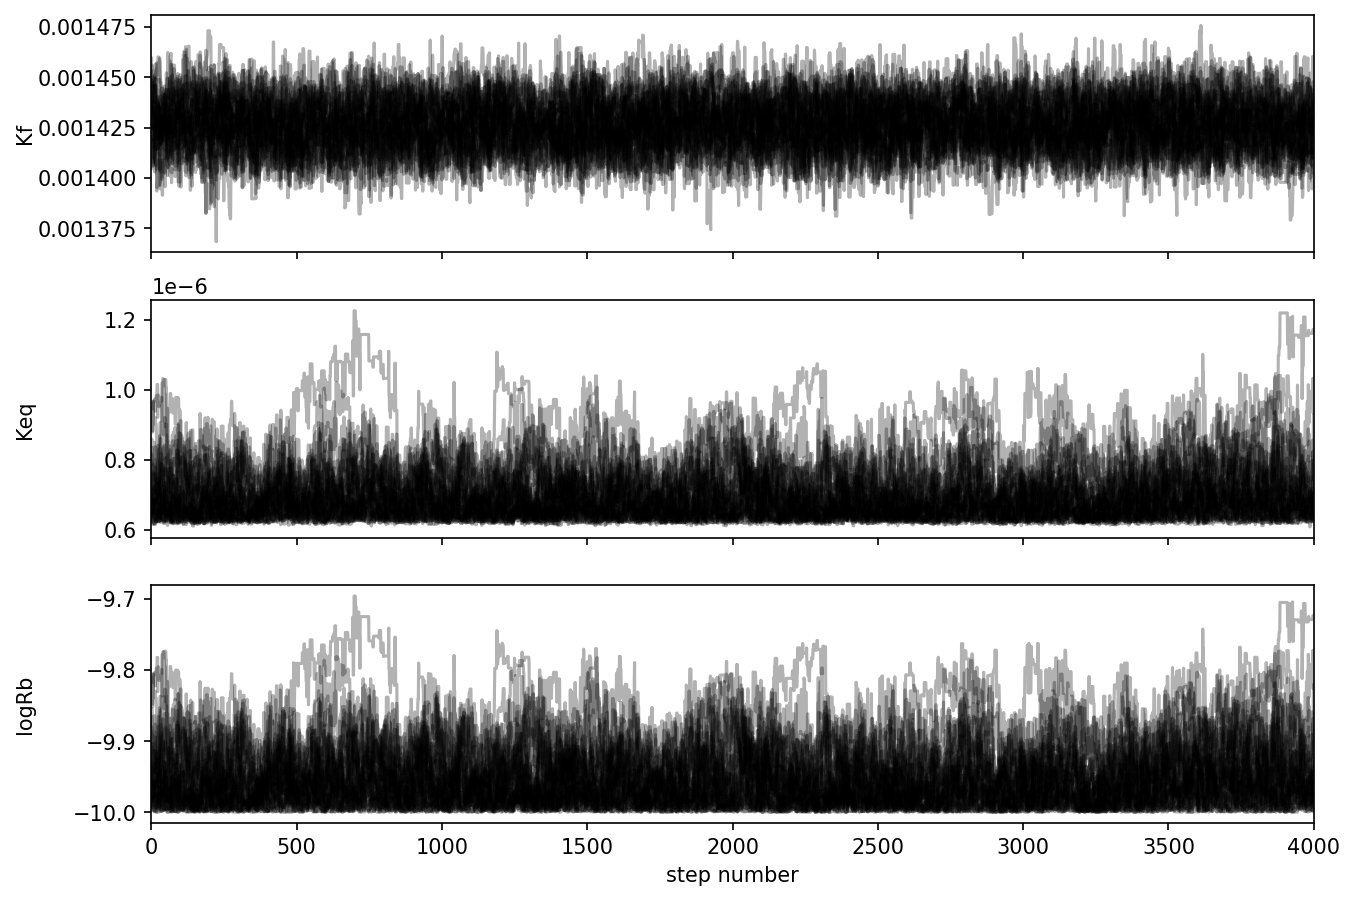

In [32]:
burnin=1000
samples = sampler.get_chain(discard=burnin)
flat_samples = sampler.get_chain(discard=burnin, flat=True)
labels = 'Kf', 'Keq', 'logRb'

fig, axs = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axs[-1].set_xlabel("step number");

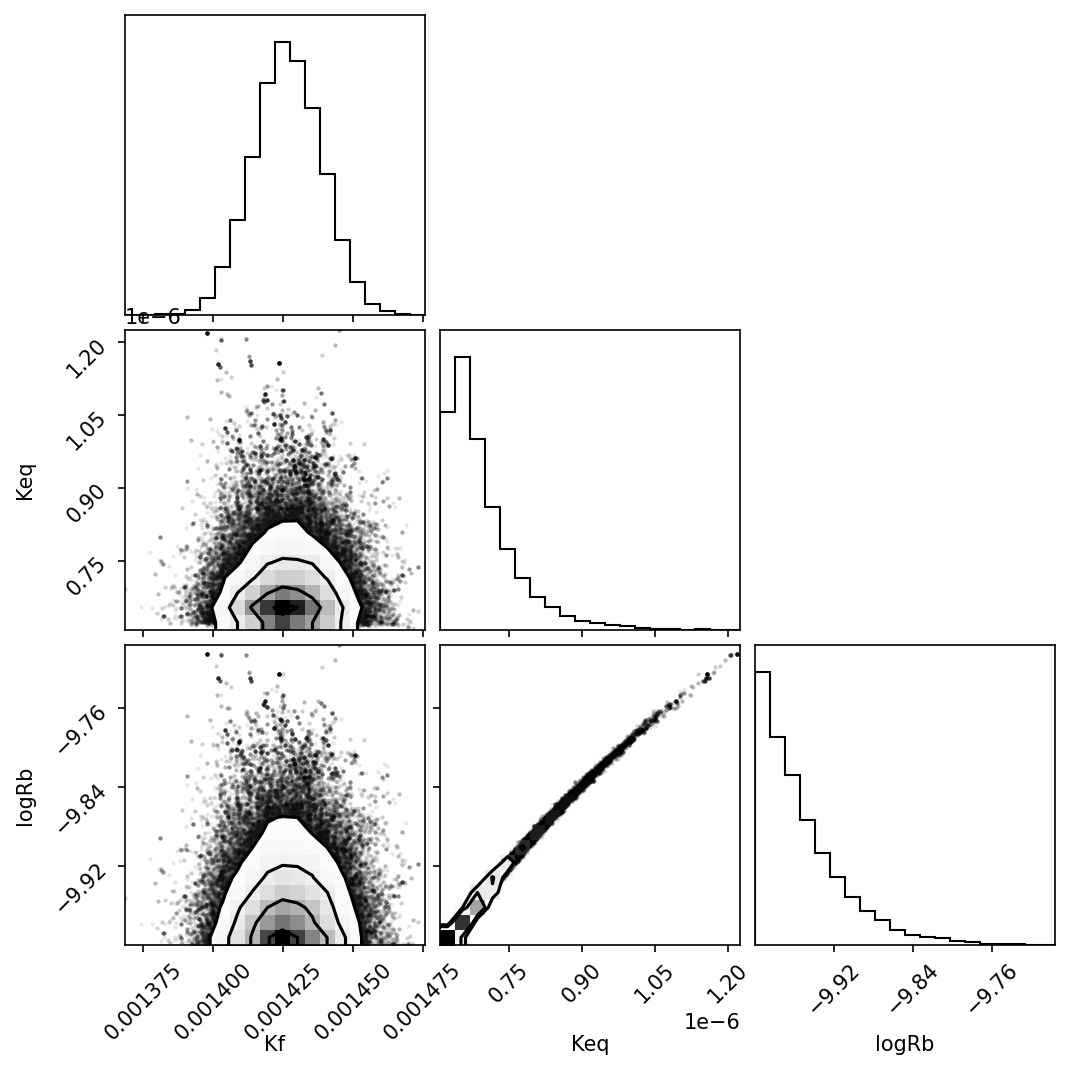

In [33]:
corner.corner(flat_samples, labels=labels);

In [34]:
nRp = np.logspace(-8.5, -5, 100)
pred = SKM(nRp.reshape(-1,1), flat_samples[:,0], flat_samples[:,1], 10**flat_samples[:,2])

CI = 0.95
plo, pmid, phi = np.quantile(pred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

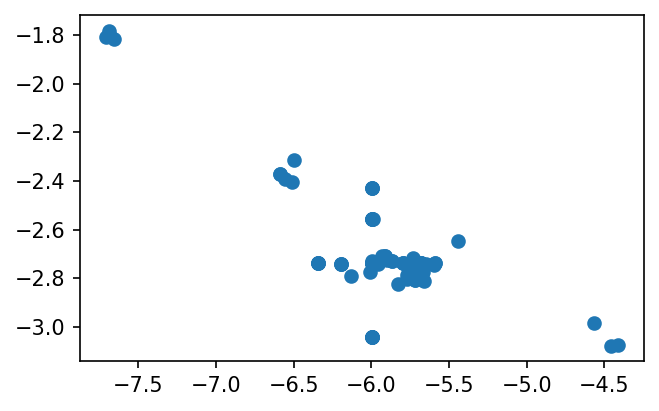

In [42]:
plt.scatter(la_OH, la_HCO3)

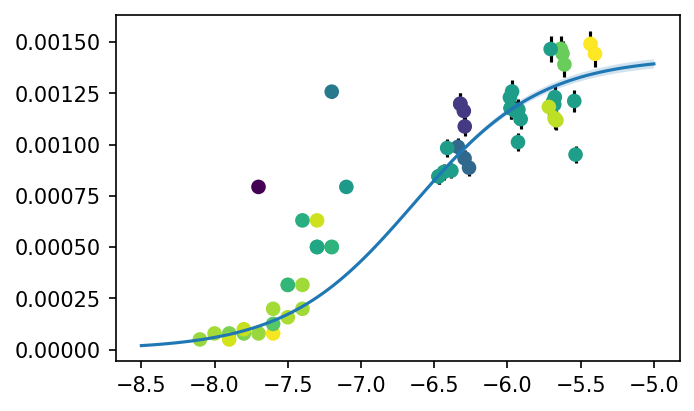

In [44]:
# laOH invariant
# ind = np.isclose(la_OH, -6, atol=0.5)

plt.errorbar(np.log10(Rp[ind]), DLi[ind], yerr=DLi_err[ind], fmt='none', c='k', zorder=-3)
plt.scatter(np.log10(Rp[ind]), DLi[ind], c=la_OH[ind])

plt.plot(np.log10(nRp), pmid)
plt.fill_between(np.log10(nRp), plo, phi, alpha=0.2)


## Variable aLi

In [ ]:
def SKM_modD(X, Kf, Keq, Rb=6e-7, modM):
    """
    DePaolo's (2011) Surface Kinetic Model
    
    Parameters
    ----------
    Kf : array-like
        The kinetic ('forward') fractionation factor.
        Kp will asymptote towards this value at high
        Rp.
    Keq : array-like
        The equilibrium fractionation factor. Kp will
        asymptote towards this values at low Rp.
    Rp : array-like
        Precipitation rate.
    Rb : array-like
        Ion detachment rate.

    Returns
    -------
    Kp : array-like
        Partitioning / fractionation of element in precipitated mineral.
    """
    Rp, modX = X
    SKM_D = Kf / (1 + Rb * (Kf / Keq - 1) / (Rp + Rb))
    
    return SKM_D * modX * modM

def log_prior(theta):
    Kf, Keq, logRb = theta
    if np.any(Kf < 0) or np.any(Keq < 0):
        return -np.inf

    return np.sum(stats.truncnorm.logpdf(logRb, loc=-7, scale=1, a=-3, b=2))
    
def log_likelihood(theta, Rp, DLi, Rp_err, DLi_err):
    Kf, Keq, logRb = theta
    model = SKM(Rp, Kf, Keq, 10**logRb)
    sigma2 = DLi_err**2 + Rp_err**2
    return -0.5 * np.sum((DLi - model)**2 / sigma2 + np.log(sigma2))

def log_probability(theta, Rp, DLi, Rp_err, DLi_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Rp, DLi, Rp_err, DLi_err)

## Variable Kf

In [154]:
def calc_Kvar1(Kx1, theta):
    K0, Km1 = theta
    return K0 + Kx1 * Km1

def calc_Kvar2(Kx1, Kx2, theta):
    K0, Km1, Km2 = theta
    return K0 + Kx1 * Km1 + Kx2 * Km2

def log_probability_Kfvar1(theta, Rp, Kfx1, DLi, Rp_err, DLi_err):
    *_, Keq, logRb = theta
    Kf = calc_Kvar1(Kfx1, theta[:2])
    
    lp = log_prior((Kf, Keq, logRb))
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood((Kf, Keq, logRb), Rp, DLi, Rp_err, DLi_err)

def log_probability_Kfvar2(theta, Rp, Kfx1, Kfx2, DLi, Rp_err, DLi_err):
    *_, Keq, logRb = theta
    Kf = calc_Kvar2(Kfx1, Kfx2, theta[:3])
    
    lp = log_prior((Kf, Keq, logRb))
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood((Kf, Keq, logRb), Rp, DLi, Rp_err, DLi_err)

def 

In [150]:
Kfx1 = mu
Kfx1 -= Kfx1.mean()
Kfx1 /= Kfx1.std()

Kfx2 = la_OH
Kfx2 -= Kfx2.mean()
Kfx2 /= Kfx2.std()

initial = 0.0014, 0, 0, 1e-5, -8

nwalkers = 32
ndim = len(initial)

start = initial + 1e-7 * np.random.randn(nwalkers, len(initial))

# ind = np.isclose(la_OH, -6, atol=0.5)
ind = np.ones(Rp.shape, dtype=bool)
inputs = (Rp[ind], Kfx1[ind], Kfx2[ind], DLi[ind], Rp_err[ind], DLi_err[ind])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_Kfvar2, args=inputs)
sampler.run_mcmc(start, 5000, progress=True);


100%|██████████| 5000/5000 [00:22<00:00, 222.78it/s]


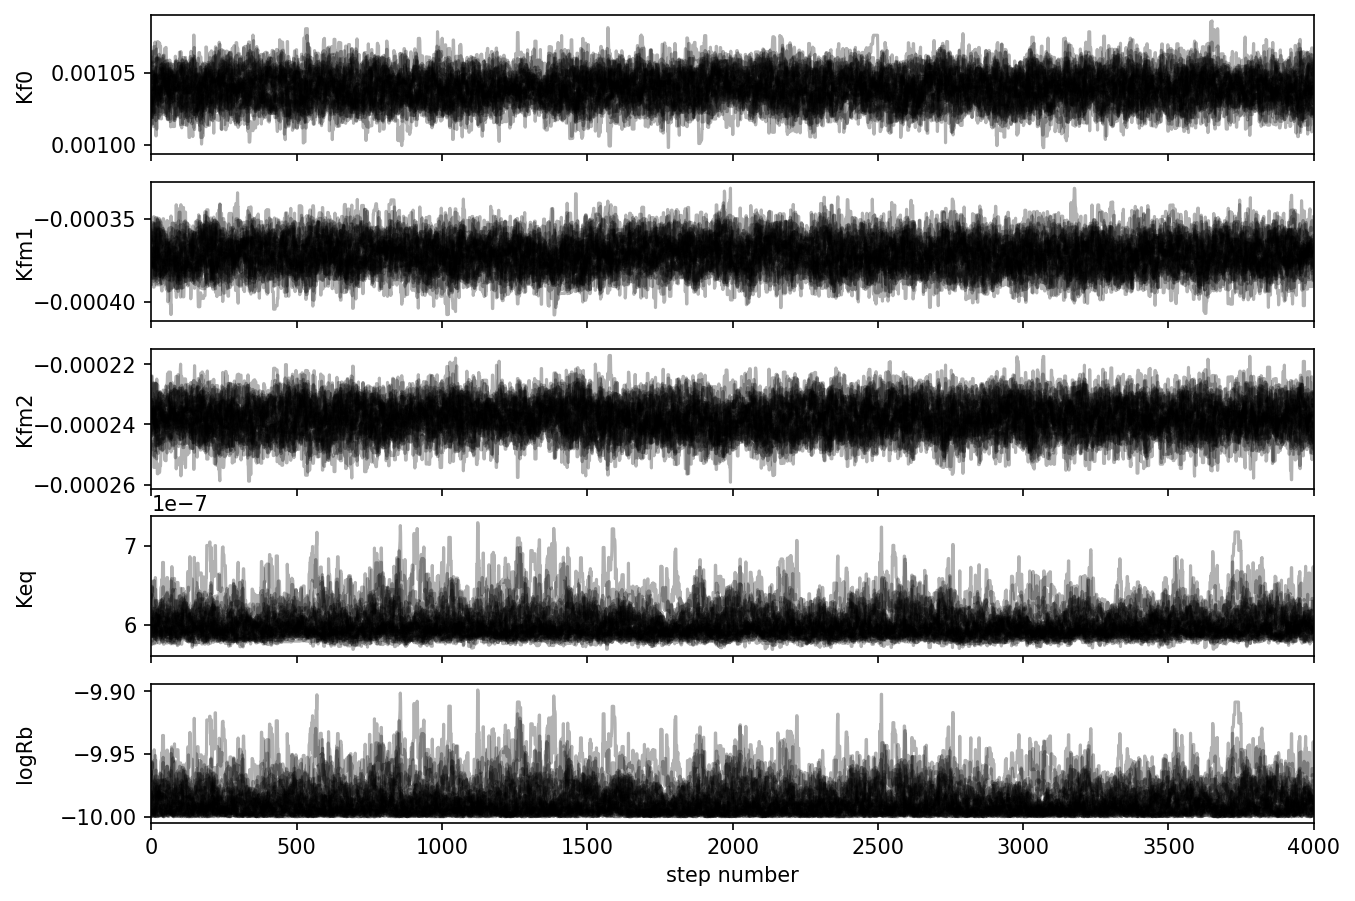

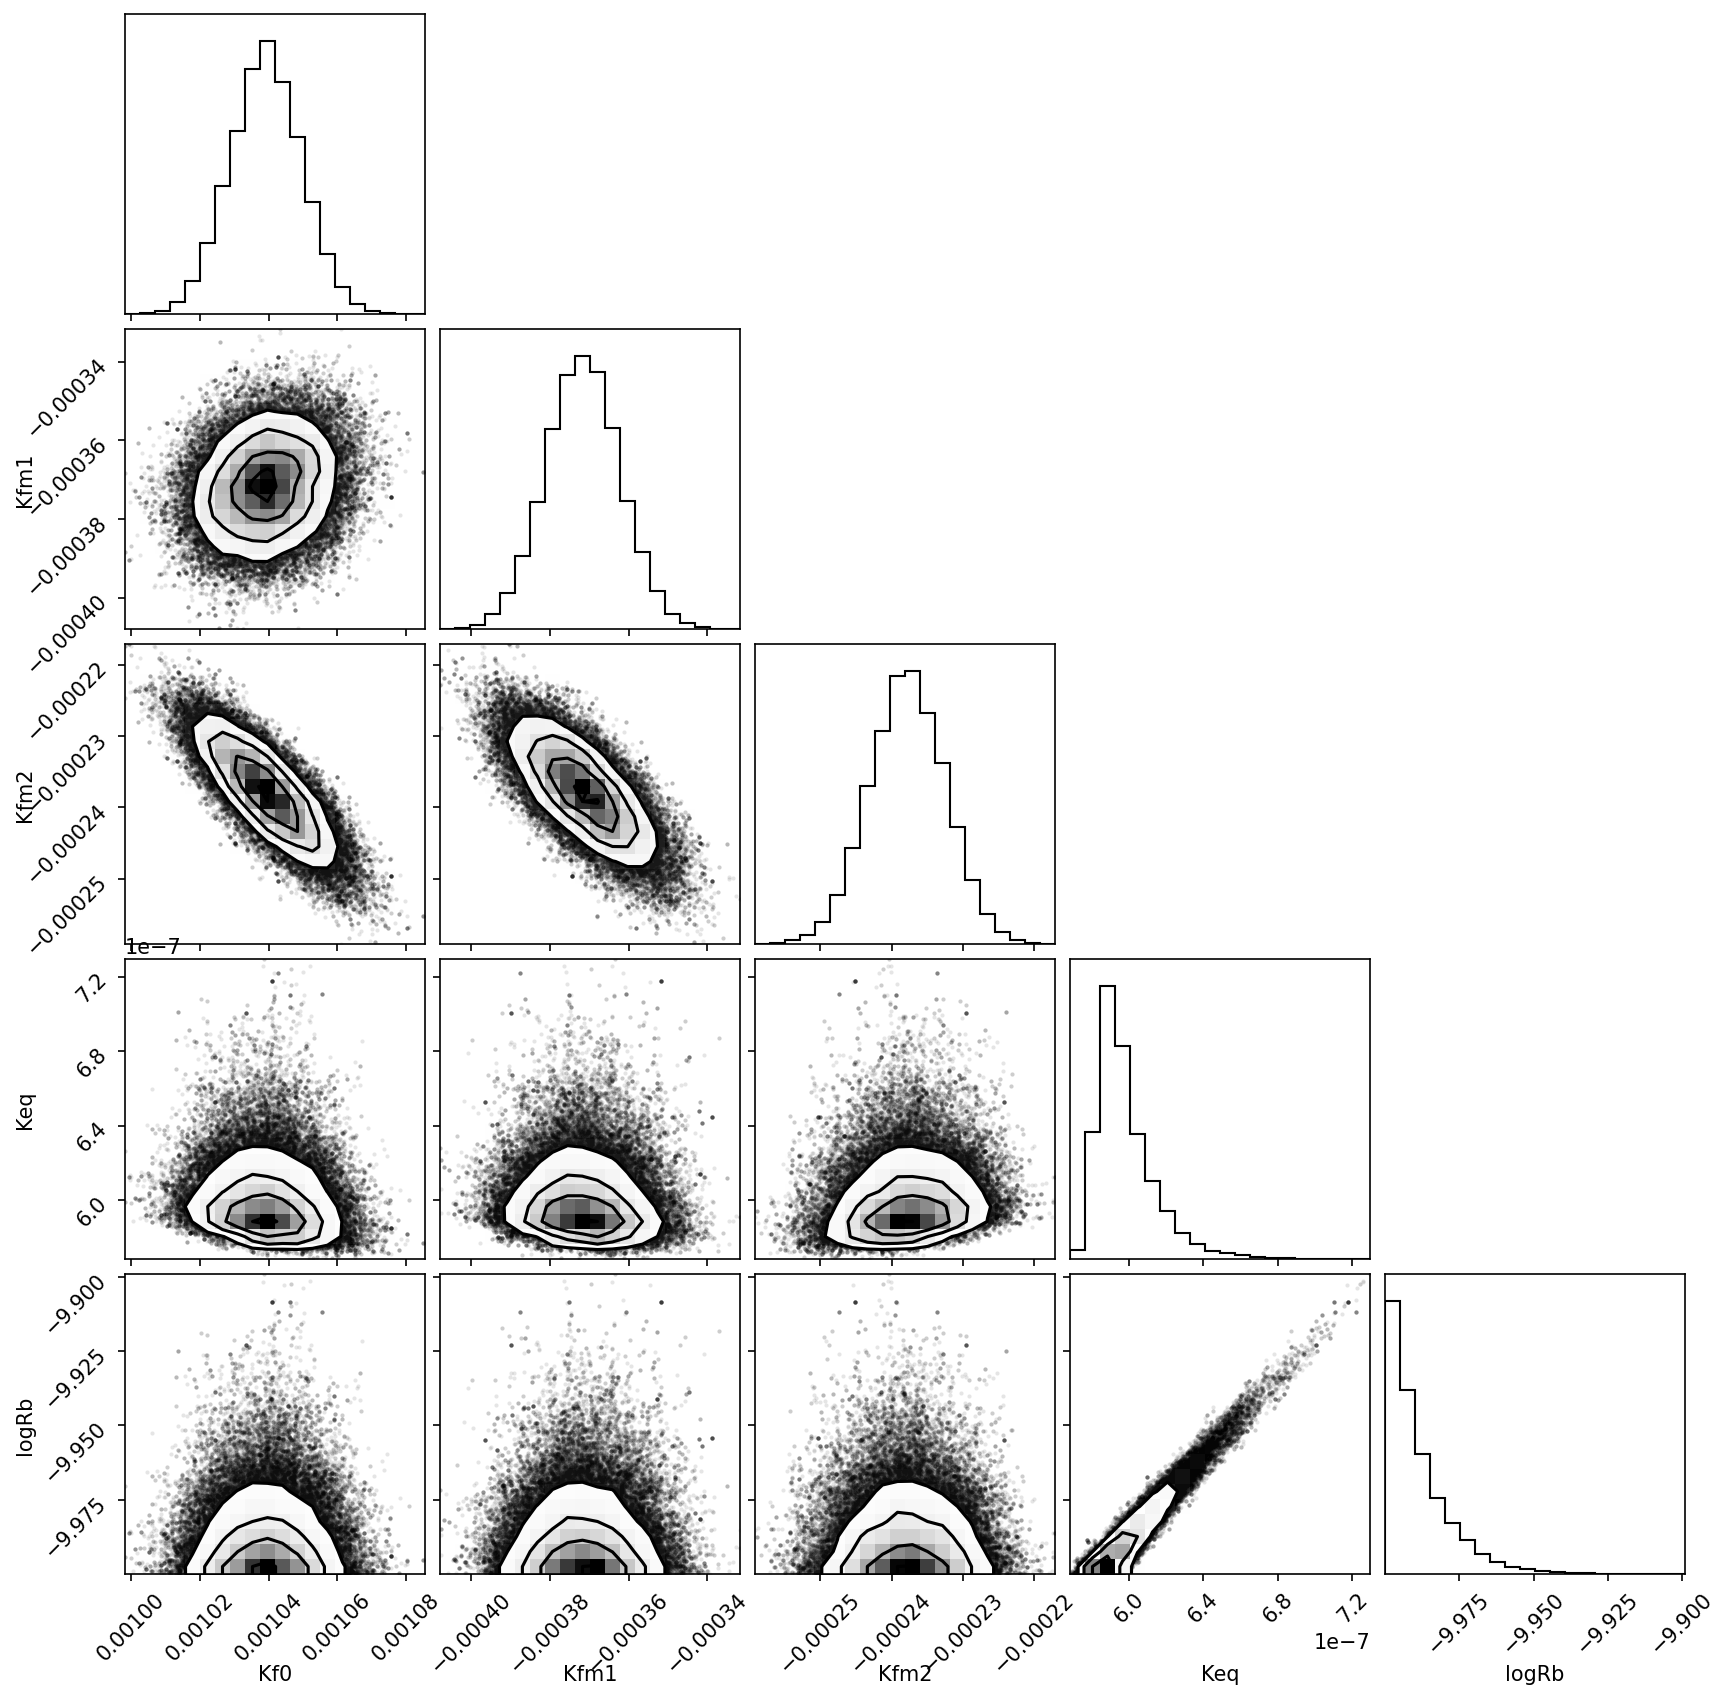

In [151]:
burnin=1000
samples = sampler.get_chain(discard=burnin)
flat_samples = sampler.get_chain(discard=burnin, flat=True)
labels = 'Kf0', 'Kfm1', 'Kfm2', 'Keq', 'logRb'

fig, axs = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axs[-1].set_xlabel("step number");

corner.corner(flat_samples, labels=labels);

In [155]:
nRp = np.logspace(-8.5, -5, 100)

pred = SKM(nRp.reshape(-1,1), flat_samples[:,0], flat_samples[:,-2], 10**flat_samples[:,-1])

CI = 0.95
plo, pmid, phi = np.quantile(pred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

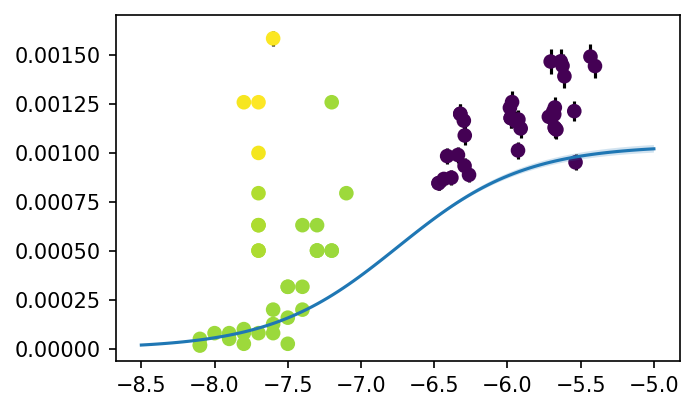

In [156]:
plt.errorbar(np.log10(Rp[ind]), DLi[ind], yerr=DLi_err[ind], fmt='none', c='k', zorder=-3)
plt.scatter(np.log10(Rp[ind]), DLi[ind], c=Kfx1[ind])

plt.plot(np.log10(nRp), pmid)
plt.fill_between(np.log10(nRp), plo, phi, alpha=0.2)

In [157]:
pred_Kf = calc_Kvar2(Kfx1.reshape(-1,1), Kfx2.reshape(-1,1), flat_samples.T[:3])

dpred = SKM(Rp.reshape(-1,1), pred_Kf, flat_samples[:,-2], 10**flat_samples[:,-1])

dplo, dpmid, dphi = np.quantile(dpred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

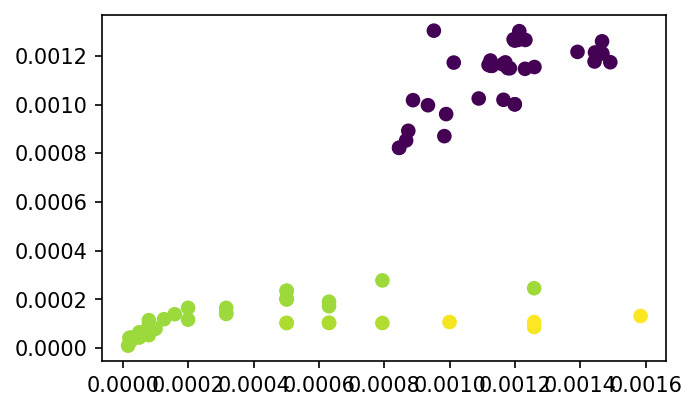

In [159]:
plt.scatter(DLi, dpmid, c=Kfx1)

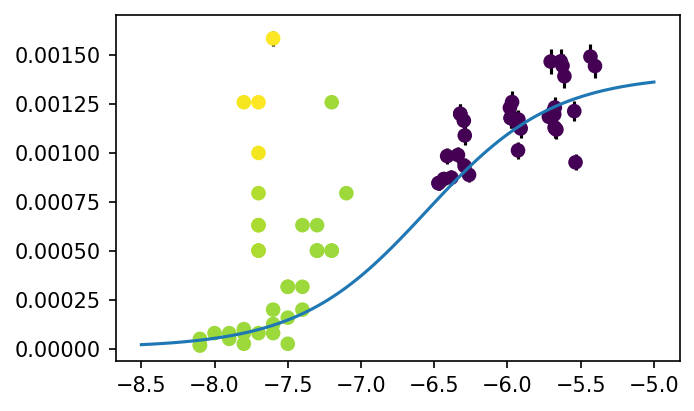

In [172]:
plt.errorbar(np.log10(Rp), DLi, yerr=DLi_err, fmt='none', c='k', zorder=-3)
plt.scatter(np.log10(Rp), DLi, c=Kfx1)

plt.plot(np.log10(nRp), SKM(nRp, 0.0014, 5e-6, 1e-9))

# plt.plot(np.log10(nRp), SKM(nRp, 0.003, 5e-6, 1e-9))